<figure>
    <img src="../_images/dnd-logo.png" alt="Dungeons and Dragons Logo!"/>
    <figure-caption>image from https://www.enworld.org/resources/d-d-5e-logo-pack.1043/</figure-caption>
</figure>

# An Analysis of Dungeons and Dragons 5ed Monsters 
## Using data found from [Patrick Gomes at Kaggle](https://www.kaggle.com/datasets/patrickgomes/dungeons-and-dragons-5e-monsters/data) I will look to see if I can answer a few questions regarding the diversity of monsters in Dungeons and Dragons Fifth Edition (to be called 5e for the remainder of this project). I will pose the following questions
### 1. What are the most common monster types (shown as race in this data)?
### 2. Is there a noticeable disparity between monster types?
### 3. Is there any connection between monster type and alignment?
### 4. Does monster size impact hit point amounts?
### 5. Does a monster’s armor class have a correlation with its speed or hit points?

In [1]:
#import libraries used for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read in the CSV file and see a preview of the data
dnd = pd.read_csv('Dd5e_monsters.csv')
dnd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Name                    324 non-null    object
 1   Size                    324 non-null    object
 2   Race + alignment        324 non-null    object
 3   HP                      324 non-null    object
 4   Armor                   324 non-null    object
 5   Speed                   324 non-null    object
 6   Challenge rating  (XP)  324 non-null    object
dtypes: object(7)
memory usage: 17.8+ KB


In [3]:
#look over the columns names and first three rows worth of data
dnd.head(3)

,Name,Size,Race + alignment,HP,Armor,Speed,Challenge rating (XP)
0,Aboleth,Large,"aberration, Lawful Evil",135 (18d10+36),17 (Natural Armor),"10 ft., swim 40 ft.","10 (5,900 XP)"
1,Acolyte,Medium,"humanoid (any race), Any Alignment",9 (2d8),10,30 ft.,1/4 (50 XP)
2,Adult Black Dragon,Huge,"dragon, Chaotic Evil",195 (17d12+85),19 (Natural Armor),"40 ft., fly 80 ft., swim 40 ft.","14 (11,500 XP)"


In [4]:
#Check for any null values even those this data set looks pretty clean at a glance
dnd.isnull().sum()

Name                      0
Size                      0
Race + alignment          0
HP                        0
Armor                     0
Speed                     0
Challenge rating  (XP)    0
dtype: int64

## What are the most common monster types (shown as race in this data)?

To work on this question I plan on splitting up Race+Alignment into two separate columns

In [46]:
# found that some of the data had multiple commas, so starting from the end of the string was the trick
dnd[['Race','Alignment']] = dnd['Race + alignment'].str.rsplit(',', n=1, expand=True)
dnd['Alignment'] = dnd['Alignment'].str.strip()

In [6]:
dnd

,Name,Size,Race + alignment,HP,Armor,Speed,Challenge rating (XP),Race,Alignment
0,Aboleth,Large,"aberration, Lawful Evil",135 (18d10+36),17 (Natural Armor),"10 ft., swim 40 ft.","10 (5,900 XP)",aberration,Lawful Evil
1,Acolyte,Medium,"humanoid (any race), Any Alignment",9 (2d8),10,30 ft.,1/4 (50 XP),humanoid (any race),Any Alignment
2,Adult Black Dragon,Huge,"dragon, Chaotic Evil",195 (17d12+85),19 (Natural Armor),"40 ft., fly 80 ft., swim 40 ft.","14 (11,500 XP)",dragon,Chaotic Evil
3,Adult Blue Dragon,Huge,"dragon, Lawful Evil",225 (18d12+108),19,"40 ft., burrow 30 ft., fly 80 ft.","16 (15,000 XP)",dragon,Lawful Evil
4,Adult Brass Dragon,Huge,"dragon, Chaotic Good",172 (15d12+75),18 (Natural Armor),"40 ft., burrow 40 ft., fly 80 ft.","13 (10,000 XP)",dragon,Chaotic Good
...,...,...,...,...,...,...,...,...,...
319,Young Green Dragon,Large,"dragon, Lawful Evil",136 (16d10+48),18 (Natural Armor),"40 ft., fly 80 ft., swim 40 ft.","8 (3,900 XP)",dragon,Lawful Evil
320,Young Red Dragon,Large,"dragon, Chaotic Evil",178 (17d10+85),18 (Natural Armor),"40 ft., climb 40 ft., fly 80 ft.","10 (5,900 XP)",dragon,Chaotic Evil
321,Young Silver Dragon,Large,"dragon, Lawful Good",168 (16d10+80),18 (Natural Armor),"40 ft., fly 80 ft.","9 (5,000 XP)",dragon,Lawful Good
322,Young White Dragon,Large,"dragon, Chaotic Evil",133 (14d10+56),17 (Natural Armor),"40 ft., burrow 20 ft., fly 80 ft., swim 40 ft.","6 (2,300 XP)",dragon,Chaotic Evil


In [7]:
different_races_count = dnd['Race'].value_counts()
different_races = dnd['Race'].value_counts().keys()

In [8]:
dnd['Race'].value_counts().keys()

Index(['beast', 'dragon', 'monstrosity', 'humanoid (any race)', 'undead',
       'elemental', 'giant', 'swarm of tiny beasts', 'fiend (devil)',
       'construct', 'fiend (demon)', 'fey', 'plant', 'celestial', 'aberration',
       'humanoid (human, shapechanger)', 'ooze', 'fiend',
       'humanoid (goblinoid)', 'monstrosity (shapechanger)',
       'Fiend (Shapechanger)', 'monstrosity (titan)', 'humanoid (dwarf)',
       'humanoid (gnome)', 'humanoid (merfolk)', 'humanoid (sahuagin)',
       'humanoid (grimlock)', 'humanoid (gnoll)', 'humanoid (human)',
       'fiend (devil, shapechanger)', 'humanoid (kobold)', 'humanoid (orc)',
       'humanoid (lizardfolk)', 'humanoid (elf)', 'undead (shapechanger)',
       'fiend (shapechanger)'],
      dtype='object')

In [9]:
different_races_count

beast                             87
dragon                            43
monstrosity                       35
humanoid (any race)               21
undead                            17
elemental                         16
giant                             10
swarm of tiny beasts              10
fiend (devil)                      9
construct                          9
fiend (demon)                      8
fey                                6
plant                              6
celestial                          6
aberration                         5
humanoid (human, shapechanger)     5
ooze                               4
fiend                              4
humanoid (goblinoid)               3
monstrosity (shapechanger)         2
Fiend (Shapechanger)               2
monstrosity (titan)                2
humanoid (dwarf)                   1
humanoid (gnome)                   1
humanoid (merfolk)                 1
humanoid (sahuagin)                1
humanoid (grimlock)                1
h

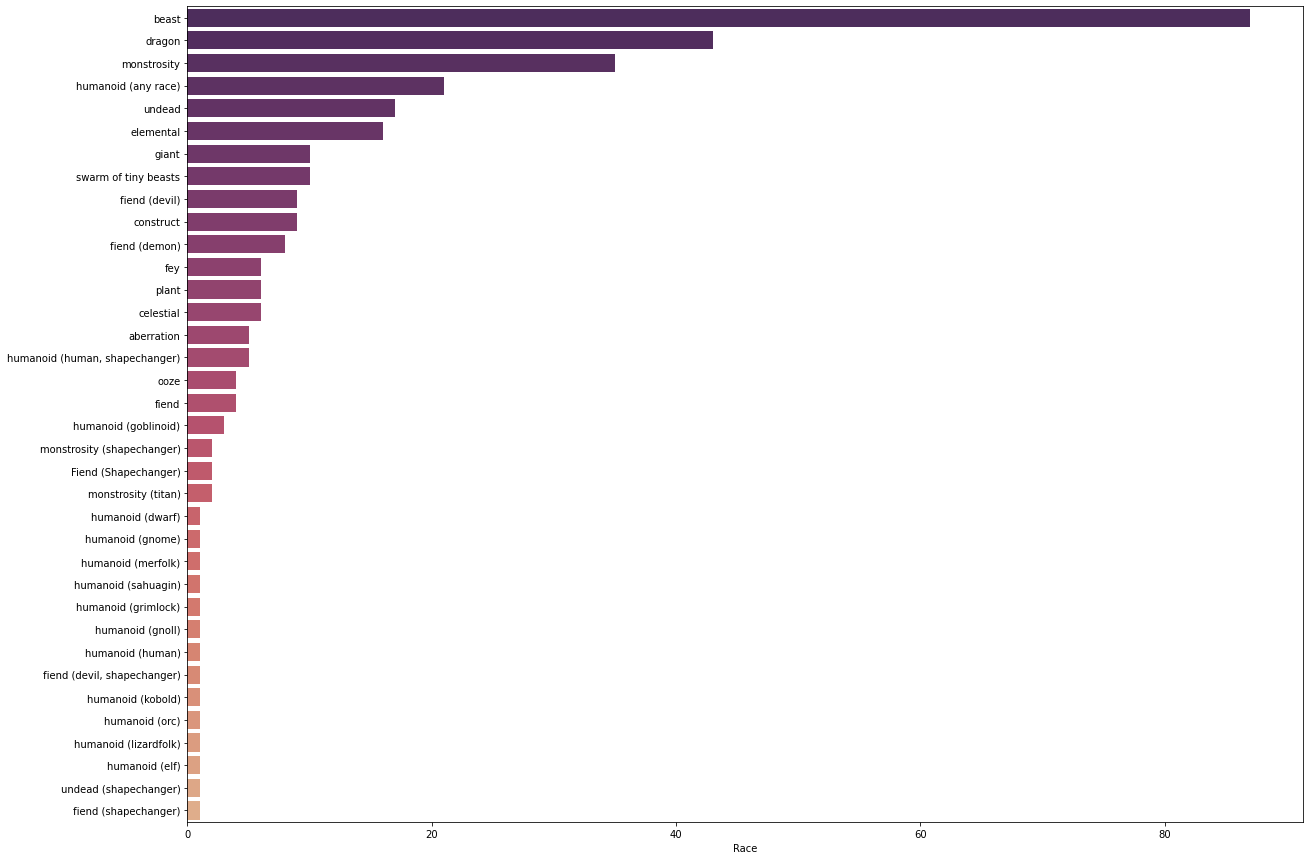

In [10]:
# Plotting out a graph to show the monsters. A lot of humanoid variants. 

fig, ax = plt.subplots(figsize=(20,15))

sns.barplot(ax=ax, x=different_races_count, y=different_races, palette='flare_r',data=dnd)

plt.show()

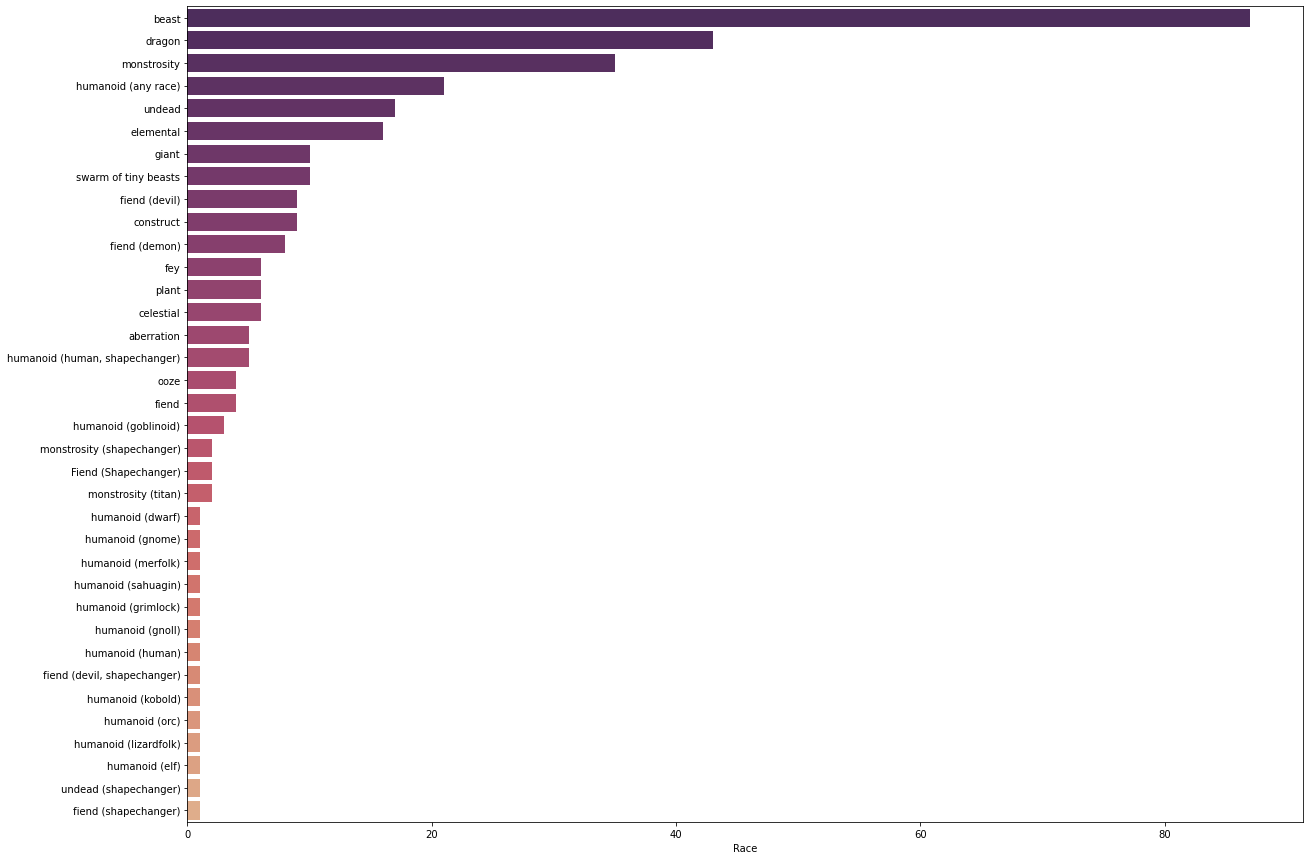

In [11]:
# Let's turn this into a function so we can change parameters more easily.
def plot_monster_races(x, y, data=None):
    fig, ax = plt.subplots(figsize=(20,15))

    ax=sns.barplot(ax=ax, x=x, y=y, palette='flare_r',data=data)
    # for b in x:
    #     ax.bar_label(b)
    plt.show()

plot_monster_races(different_races_count, different_races, dnd)
    

Even if we combined all of the humanoid variants, the number of Beasts surpasses all other individual races by double. Let's try and combine the races into fewer categories.

## Is there a noticeable disparity between monster types?

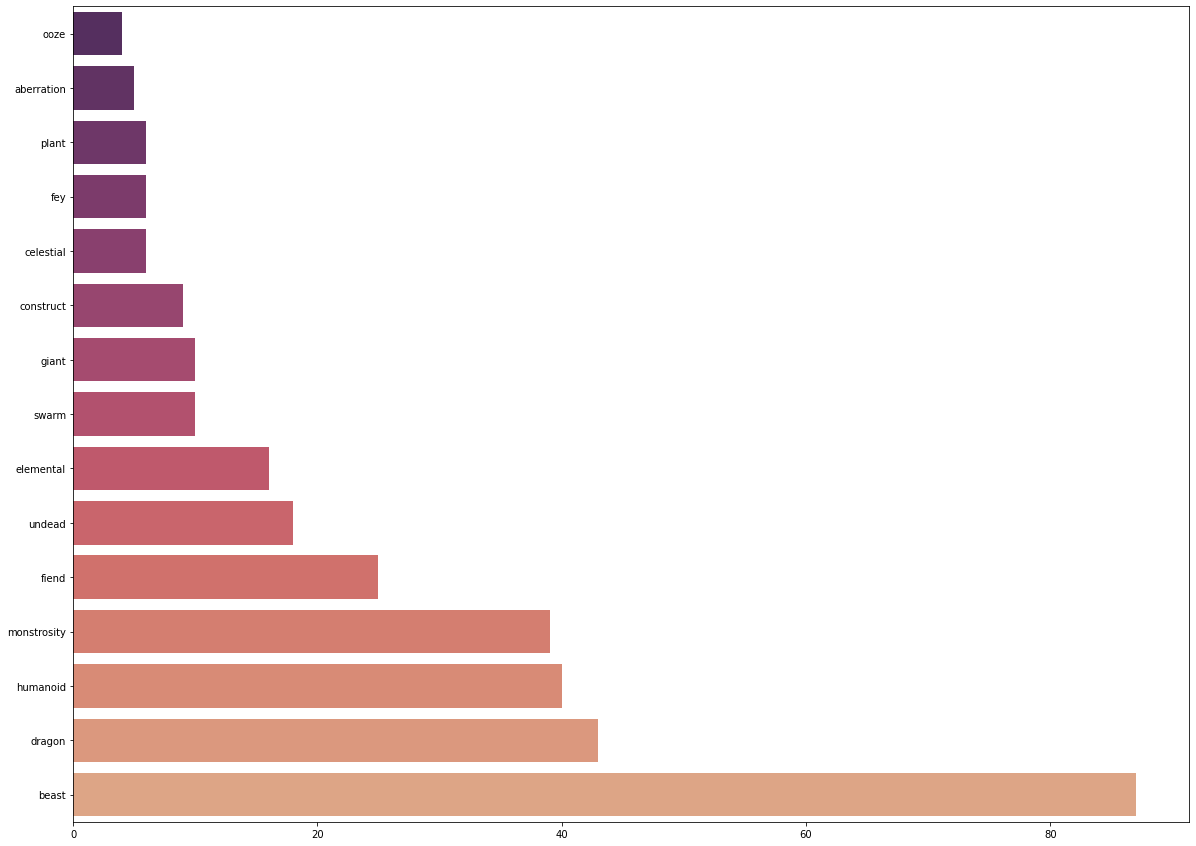

In [40]:
dnd_races = dnd['Race']
races_dict = dict()
for race in dnd_races:
    category = race.split(" ")[0].lower().strip()
    races_dict[category] = races_dict.get(category, 0)+1
races_dict = dict(sorted(races_dict.items(), key=lambda item: item[1]))
races_dict

vals = list(races_dict.values())
races = list(races_dict.keys())
plot_monster_races(vals, races)

## Is there any connection between monster type and alignment?

In [42]:
# Get an idea for which alignments we are looking at in the data
dnd['Alignment'].value_counts()

 Unaligned                                   128
 Chaotic Evil                                 44
 Lawful Evil                                  37
 Neutral Evil                                 28
 Lawful Good                                  19
 Neutral                                      19
 Any Alignment                                15
 Chaotic Good                                 12
 Neutral Good                                  6
 Any Non-good Alignment                        4
 Lawful Neutral                                3
 Chaotic Neutral                               3
 Any Non-lawful Alignment                      2
 Any Evil Alignment                            1
 Any                                           1
 Neutral Good (50%) Or Neutral Evil (50%)      1
 Any Chaotic Alignment                         1
Name: Alignment, dtype: int64

There are 9 alignments (and unaligned) that we care about, so let's take a look at just the basic alignments

In [57]:
alignments = ['Unaligned', 
              'Chaotic Evil', 'Lawful Evil', 'Neutral Evil', 
              'Chaotic Good', 'Lawful Good', 'Neutral Good', 
              'Neutral', 'Chaotic Neutral', 'Lawful Neutral']

dnd['True Alignment'] = dnd['Alignment'].apply(lambda alignment: 1 if alignment in alignments else 0)
dnd.head()

,Name,Size,Race + alignment,HP,Armor,Speed,Challenge rating (XP),Race,Alignment,True Alignment
0,Aboleth,Large,"aberration, Lawful Evil",135 (18d10+36),17 (Natural Armor),"10 ft., swim 40 ft.","10 (5,900 XP)",aberration,Lawful Evil,1
1,Acolyte,Medium,"humanoid (any race), Any Alignment",9 (2d8),10,30 ft.,1/4 (50 XP),humanoid (any race),Any Alignment,0
2,Adult Black Dragon,Huge,"dragon, Chaotic Evil",195 (17d12+85),19 (Natural Armor),"40 ft., fly 80 ft., swim 40 ft.","14 (11,500 XP)",dragon,Chaotic Evil,1
3,Adult Blue Dragon,Huge,"dragon, Lawful Evil",225 (18d12+108),19,"40 ft., burrow 30 ft., fly 80 ft.","16 (15,000 XP)",dragon,Lawful Evil,1
4,Adult Brass Dragon,Huge,"dragon, Chaotic Good",172 (15d12+75),18 (Natural Armor),"40 ft., burrow 40 ft., fly 80 ft.","13 (10,000 XP)",dragon,Chaotic Good,1


In [38]:
dnd['Alignment'].unique()

array([' Lawful Evil', ' Any Alignment', ' Chaotic Evil', ' Chaotic Good',
       ' Lawful Good', ' Neutral', ' Lawful Neutral', ' Unaligned',
       ' Any Non-good Alignment', ' Any Non-lawful Alignment',
       ' Neutral Evil', ' Any Chaotic Alignment', ' Neutral Good',
       ' Chaotic Neutral', ' Neutral Good (50%) Or Neutral Evil (50%)',
       ' Any', ' Any Evil Alignment'], dtype=object)

<AxesSubplot:xlabel='Race', ylabel='Alignment'>

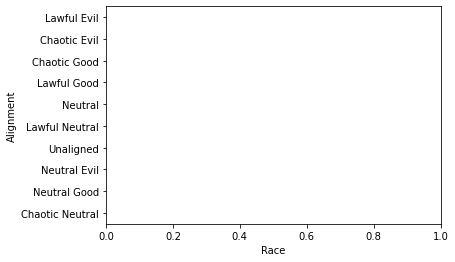

In [62]:
true_alignments = dnd[dnd['True Alignment'] == 1]

sns.boxplot(x=true_alignments['Race'].value_counts(), y=true_alignments['Alignment'])

## Does monster size impact hit point amounts?

In [24]:
monster_size_and_hp = dnd[['Size', 'HP']]
monster_size = monster_size_and_hp['Size']
monster_hp = monster_size_and_hp['HP']

<AxesSubplot:xlabel='HP', ylabel='Size'>

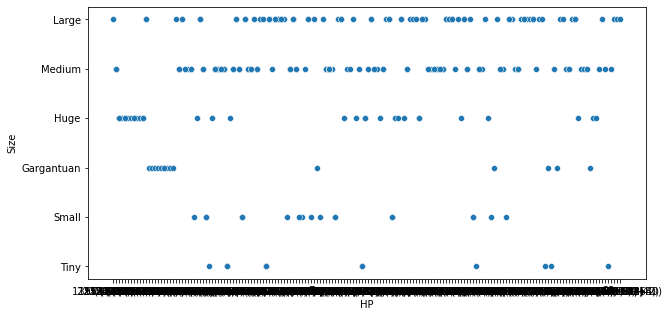

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x=monster_hp, y=monster_size, data=monster_size_and_hp)

## Does a monster’s armor class have a correlation with its speed or hit points?